# Assignment 2: Neural Machine Translation

### Step 0: Download and unzip the dataset

In [1]:
# see http://www.manythings.org/anki

! wget http://www.manythings.org/anki/fra-eng.zip
    
! unzip fra-eng.zip

--2021-04-15 21:59:03--  http://www.manythings.org/anki/fra-eng.zip
Résolution de www.manythings.org (www.manythings.org)… 172.67.173.198, 104.21.55.222, 2606:4700:3036::ac43:adc6, ...
Connexion à www.manythings.org (www.manythings.org)|172.67.173.198|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 6281268 (6,0M) [application/zip]
Sauvegarde en : « fra-eng.zip.1 »

fra-eng.zip.1       100%[===================>]   5,99M  --.-KB/s    ds 0,05s   

2021-04-15 21:59:05 (112 MB/s) — « fra-eng.zip.1 » sauvegardé [6281268/6281268]

Archive:  fra-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
import re, string

### Step 1: Reading the dataset

In [2]:
with open('fra.txt', 'r') as fr:
    
    nmt_data = []
    
    for lines in fr.readlines():
        splits = lines.split('\t')
        
        i = {
            'src': splits[1],
            'tgt': splits[0]
        }
        
        nmt_data.append(i)

In [3]:
## Save vocab_file

with open('src_vocab.txt', 'w') as src:
    el = ' '.join([a['src'] for a in nmt_data])
    src.write(el)

with open('tgt_vocab.txt', 'w') as tgt:
    el = ' '.join([a['tgt'] for a in nmt_data])
    tgt.write(el)

In [4]:
nmt_data[10000]

{'src': "J'ai payé en espèce.", 'tgt': 'I paid in cash.'}

### Step 3: Setting tokenizers

In [5]:
import tokenizers
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import WordLevel
from tokenizers.processors import TemplateProcessing

from tokenizers import normalizers
from tokenizers.normalizers import Lowercase, NFD, StripAccents

In [6]:
def create_tokenizer(vocab_file, vocab_size=30000, single_format='[SOS] $A [EOS]'):
    
    # Instanciate a trainer
    trainer = tokenizers.trainers.WordLevelTrainer(vocab_size=vocab_size, special_tokens=['[PAD]', '[SOS]', '[EOS]', '[UNK]'])
    
    # Instanciate a tokenizer
    tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
    
    # Adding pre-tokenizer
    tokenizer.pre_tokenizer = Whitespace()
    
    # Adding normalizers
    tokenizer.normalizer = normalizers.Sequence([Lowercase(), NFD(), StripAccents()])
    
    # Post-Processing
    tokenizer.post_processor = TemplateProcessing(
        single=single_format,
        special_tokens=[
            ("[SOS]", 1), 
            ("[EOS]", 2)
        ]
    )
    
    # Train
    tokenizer.train([vocab_file], trainer)
    
    return tokenizer

In [7]:
src_tokenizer = create_tokenizer('src_vocab.txt', single_format='$A')

tgt_tokenizer = create_tokenizer('tgt_vocab.txt', single_format='[SOS] $A [EOS]')

In [8]:
def switch_mode(tokenizer, max_len=200):
    tokenizer.enable_truncation(max_len)
    tokenizer.enable_padding()

In [9]:
src_tokenizer.encode(nmt_data[10000]['tgt']).ids

[7767, 3, 8091, 21745, 4]

### Step 4: Creating dataset and dataloaders

In [34]:
# import librairies ...
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import seaborn as sns

In [11]:
class NMTdata(Dataset):
    
    def __init__(self, data):
        
        self.data = data
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        
        current = self.data[idx]
        
        return current['src'], current['tgt']

In [12]:
tt = NMTdata(nmt_data)

In [13]:
def collate(batch):
    
    src = [item[0] for item in batch]
    tgt = [item[1] for item in batch]
    
    switch_mode(src_tokenizer)
    switch_mode(tgt_tokenizer)
    
    src = src_tokenizer.encode_batch(src)
    src = torch.LongTensor([i.ids for i in src])
    
    tgt = tgt_tokenizer.encode_batch(tgt)
    tgt = torch.LongTensor([i.ids for i in tgt])
                
    return [src, tgt]

In [14]:
all_dataset = NMTdata(nmt_data)

print(len(all_dataset))

train, val = random_split(all_dataset, [len(all_dataset)-5000, 5000])

train_loader = DataLoader(train, batch_size=256, shuffle=True, collate_fn=collate, num_workers=15)

val_loader = DataLoader(val, batch_size=512, shuffle=False, collate_fn=collate, num_workers=11)

185583


### Step 4: Creating Encoder Decoder model

same as bahdanau et al., 2015 (https://arxiv.org/abs/1409.0473)

* bi-GRU as Encoder: the formard method should return a tensor containing all the encoder's hidden states (context vectors)
* Use/Implement attention mecanism (bahdanau, dot product, bilinear, ...)
* GRU as Decoder: the formard method should return the predicted sequence, the last hidden state of the decoder and the attention vector at each timesteps

See Notebook 014-3 for inspiration ...

In [16]:
### import modules
import numpy as np
from torch import nn
import torch.nn.functional as F

from transformer_utils import get_masks

In [17]:
# standard dot product attention

def attention(query, key, value, mask=None):
    
    d_model = query.size(-1)
    
    score = query @ key.transpose(-1, -2) / np.sqrt(d_model)
    
    ## mask and score have to be broadcastable
    ## For understanding array broadcasting see https://numpy.org/doc/stable/user/basics.broadcasting.html
    if mask != None:
        score = score.masked_fill_(mask == 0, float('-inf'))

    normalized_score = torch.softmax(score, dim=-1)
    
    output = normalized_score @ value
        
    return output, normalized_score

In [19]:
class DoubleRNN(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        
        self.rnn_1 = nn.GRU(d_model, d_model, batch_first=True, bidirectional=True, dropout=0.1)
        self.rnn_2 = nn.GRU(d_model * 2, d_model, batch_first=True, dropout=0.1)
        
    def forward(self, x, seq_len):
        
        x = nn.utils.rnn.pack_padded_sequence(x, seq_len, batch_first=True, enforce_sorted=False)
        
        x, h = self.rnn_1(x)
                
        x, h = self.rnn_2(x)
        
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
                
        return x, h # [batch_size, len, dim]

In [23]:
class NMTmodel(nn.Module):
    def __init__(self, src_vocab=src_tokenizer.get_vocab_size(), tgt_vocab=tgt_tokenizer.get_vocab_size(), d_model=512):
        super().__init__()
        
        self.tgt_vocab = tgt_vocab
        
        self.drop = nn.Dropout(0.1)
        
        self.scr_embedding = nn.Embedding(src_vocab, d_model, padding_idx=0)
        
        self.tgt_embedding = nn.Embedding(tgt_vocab, d_model, padding_idx=0)
                
        self.rnn_encoder = DoubleRNN(d_model)
        
        self.rnn_decoder = nn.GRUCell(d_model, d_model)
        
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model * 2, tgt_vocab)
        )
        
    def encode(self, x):
        
        mask, _ = get_masks(x)
        
        x_emb = self.drop(self.scr_embedding(x))
        
        lens = mask.sum(-1).squeeze().cpu()
                
        context, h = self.rnn_encoder(x_emb, lens) # bs, len, dim * 2
        
        bs, slen, _ = context.size()
        
        return context, h, mask
    
    def decode_step(self, y_t, context, h_t, mask=None):
            
        y_t = self.drop(self.tgt_embedding(y_t))
                
        h_t = self.rnn_decoder(y_t, h_t)
        
        output, normalized_score = attention(h_t.unsqueeze(1), context, context, mask)
        
        pred = self.fc(output)
        
        return pred, normalized_score, h_t
    
    
    def decode(self, y, context, h_t=None, mask=None):
            
        bs, slen = y.size()
                
        outs = []
                
        for t in range(slen):
            
            pred, normalized_score, h_t = self.decode_step(y[:, t], context, h_t, mask)
            
            outs.append(pred)
        
        pred = torch.cat(outs, dim=1)
        
        return pred
            
            
    def teacher_forcing_enc_dec(self, x, y):
        
        context, h, mask = self.encode(x)
        
        outs = self.decode(y, context, h.squeeze(0), mask=mask)
        
        return outs
        
    def forward(self, src, tgt):
        raise NotImplementedError
        
    def compute_loss(self, x, y):
        
        pred = self.teacher_forcing_enc_dec(x, y[:, :-1])
        
        y = y[:, 1:]
        
        y = y.reshape(-1)
        
        pred = pred.view(-1, self.tgt_vocab)
        
        loss = F.cross_entropy(pred, y, ignore_index=0)
        
        return loss

In [24]:
model = NMTmodel()

In [25]:
for x, y in train_loader:
    y = model.compute_loss(x, y)
    break

### Step 5: Train the model

In [26]:
from tqdm import tqdm

def train_one_epoch(net: nn.Module, opt: torch.optim, dataloader: torch.utils.data.DataLoader):
    
    net.train()
    
    for param in net.parameters():
        device = param.device
        break
    
    losses = []
    
    pbar = tqdm(dataloader)
    
    for x, y in pbar:

        net.zero_grad()

        x, y = x.to(device), y.to(device)

        loss = net.compute_loss(x, y)

        loss.backward()

        opt.step()
        
        loss_item = loss.item()
        
        losses.append(loss_item)
        
        pbar.set_description(f'train_loss = {np.array(losses).mean()}')
        
    return np.array(losses).mean()

@torch.no_grad()
def validate(net: nn.Module, dataloader: torch.utils.data.DataLoader):
    
    net.eval()
    
    for param in net.parameters():
        device = param.device
        break
     
    losses = []
    
    for x, y in dataloader:

        x, y = x.to(device), y.to(device)

        loss = net.compute_loss(x, y)
        
        losses.append(loss.item())
                    
    return np.array(losses).mean()

In [27]:
model = NMTmodel().cuda()

opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [28]:
model.cuda()

for i in range(10):
    
    if i==0:
        print(validate(model, val_loader))
        
    train_one_epoch(model, opt, train_loader)
    
    print(validate(model, val_loader))

  0%|          | 0/706 [00:00<?, ?it/s]

9.590476989746094


  0%|          | 0/706 [00:00<?, ?it/s]

3.393892455101013


  0%|          | 0/706 [00:00<?, ?it/s]

2.8132535457611083


  0%|          | 0/706 [00:00<?, ?it/s]

2.4075923919677735


  0%|          | 0/706 [00:00<?, ?it/s]

2.113707661628723


  0%|          | 0/706 [00:00<?, ?it/s]

1.8759214520454406


  0%|          | 0/706 [00:00<?, ?it/s]

1.6932036995887756


  0%|          | 0/706 [00:00<?, ?it/s]

1.549120008945465


  0%|          | 0/706 [00:00<?, ?it/s]

1.449587070941925


  0%|          | 0/706 [00:00<?, ?it/s]

1.3728409647941588


train_loss = 1.1214582285192127: 100%|██████████| 706/706 [09:32<00:00,  1.23it/s]


1.3114278316497803


In [29]:
# go to cpu for prediction mode

model.cpu()
model.eval()

print('ok')

ok


### Step 6: Prediction and attention visualization

In [76]:
## see notebook 014-3 for inspiration

@torch.no_grad()
def translate(french):
    
    src = torch.LongTensor(src_tokenizer.encode(french).ids).unsqueeze(0)
        
    y = torch.LongTensor([1])
    
    lens = torch.LongTensor([src.size()[1]])
        
    context = model.scr_embedding(src)
        
    context, h_t = model.rnn_encoder(context, lens)
    
    print(src.shape)
        
    sequences = []
    att = []
    
    while True and len(sequences) < 20:
            
        pred, normalized_score, h_t = model.decode_step(y, context, h_t.squeeze(1))
                
        pred = torch.argmax(pred, -1).item()
        
        if pred == 2: # stop when eos
            break
            
        att.append(normalized_score)
        
        sequences.append(pred)
        
        y = torch.LongTensor([pred])
        
    att = torch.cat(att, dim=1)
    
    print(att.shape)
            
    return tgt_tokenizer.decode(sequences), att.squeeze().numpy()

In [77]:
nmt_data[val.indices[0]]['src']

'Fais court.'

In [98]:
example = nmt_data[val.indices[np.random.randint(0, 5000)]]

print('source:', example['src'])

print('target:', example['tgt'])

pred, att = translate(example['src'])

print('pred:', pred)

source: Je pensais que vous seriez rentrées chez vous.
target: I thought you'd gone home.
torch.Size([1, 9])
torch.Size([1, 8, 9])
pred: i thought you ' d be home .


<AxesSubplot:>

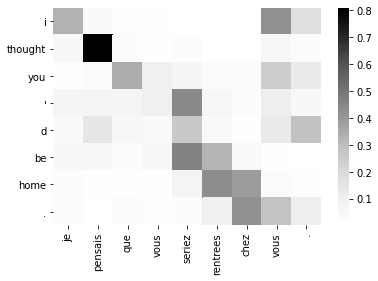

In [99]:
sns.heatmap(att, cmap='Greys', yticklabels=pred.split(' '), xticklabels=src_tokenizer.encode(example['src']).tokens)

### Step 7 (bonus): Evalute the model performance using BLEU metric